# Persistence of change

Here we adopt a very simple strategy to assess whether changes persist across an author's career.

We consider the sequence of books an author has written across their career, considering only books published in different years (duplicates in the same year are dropped). Then we create many "triplets" of sequential books, balancing these so different authors have an equal chance to be represented, as long as they have written at least three books. 

For instance a triplet centered at time *t* would be: $book_{t-1}, book_{t}, book_{t+1}$.

We then ask whether the average distance between topic proportions for the two single steps--from $t-1$ to $t$ and from $t$ to $t+1$--is larger or smaller than the total distance from $t-1$ to $t+1$.

If there's no persistent change over time for individuals, then all values for books are just $authormean \pm \epsilon$, and the mean distance across two steps should be the same as the mean distance for one step.

If, however, change is persistent, the two-step distance should be greater than the one-step distance.

We can then ask whether this ratio varies across topics, and whether it varies with age at $t-1$ or with the total distance across the triplet.

When we're considering topics individually, we measure distance simply as $|t_1 - t_2|$. When we don't need to specify topic, we can measure distance more generally using euclidean distance. (We don't use cosine distance here because its failure to satisfy triangle inequality creates an issue for the method we're attempting to implement.)

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, zscore
import random
from scipy.spatial.distance import euclidean
import statsmodels.api as sm

#### Load topic data

Then limit it to books whose authors have three or more books.

In [2]:
bookdata = pd.read_csv('../topicdata/bookleveltopicdata.tsv', sep = '\t', low_memory = False)

In [3]:
print(bookdata.shape)
bookdata = bookdata.loc[bookdata.authof3ormore == True, : ]
bookdata.shape

(10830, 208)


(10355, 208)

In [4]:
authors = list(set(bookdata.hathi_author))
random.shuffle(authors)

In [5]:
len(authors)

1714

In [6]:
bookdata.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t198,t199,docid,birthyear,firstpub,hathi_author,hathi_title,us_national,authof3ormore,age
0,0.000006,0.000031,0.011298,0.000004,0.000193,0.000005,0.000212,0.000165,0.000400,0.000138,...,0.004745,0.000002,inu.30000112046630,1911.0,1957,"Abbe, George",The winter house,False,True,46.0
1,0.000243,0.000035,0.007245,0.000004,0.000011,0.002074,0.000003,0.000009,0.000008,0.000008,...,0.035885,0.000002,uc1.$b799882,1911.0,1967,"Abbe, George",The funeral,False,True,56.0
2,0.000006,0.000005,0.012275,0.000003,0.000755,0.009934,0.000002,0.000008,0.000583,0.000278,...,0.000004,0.000002,uc1.$b149331,1911.0,1968,"Abbe, George",Yonderville,False,True,57.0
3,0.000215,0.004015,0.007680,0.001625,0.000167,0.002289,0.050386,0.000305,0.000007,0.002727,...,0.001661,0.000002,uc1.32106007981415,1927.0,1956,"Abbey, Edward",The brave cowboy : an old tale in a new time,True,True,29.0
4,0.000006,0.000005,0.000095,0.007116,0.007377,0.000231,0.062383,0.000149,0.000289,0.001048,...,0.000033,0.000002,inu.39000001136287,1927.0,1962,"Abbey, Edward",Fire on the mountain,True,True,35.0


## How many triplets are there?

In [78]:
tripletcount = 0
for auth in authors:
    authworks = bookdata.loc[bookdata.hathi_author == auth, :].copy()
    numworks = len(authworks)
    if numworks > 2:
        tripletcount = tripletcount + numworks - 2

print(tripletcount)

6927


## Measuring triplets

We create a dataframe where each row represents a triplet measurement. Each row will contain

1. The dimension measured, which could be a natural number for a single topic dimension, or -1 for euclidean distance in the whole topic space. We'll select on this column.

2. The average of both single-step measurements.

3. The double-step measurement.

4. The author's age at t-1.

5. The age gap from t-1 to t+1.

In [7]:
def maketriplets(authorselection):
    
    # We create a list for each of the 1-5 columns described above

    dimensions = []
    singlesteps = []
    doublesteps = []
    initialages = []
    agegaps = []

    ctr = 0
    errors = 0


    for auth in authorselection:
        authworks = bookdata.loc[bookdata.hathi_author == auth, :].copy()   # get all the author's books
        authworks = authworks.sample(frac = 1)                                # shuffle them
        authworks = authworks.drop_duplicates(subset = 'firstpub', keep = 'first') # keep only one per date
        authworks = authworks.sort_values(by = 'firstpub')              # sort them by date

        if len(authworks) < 3:      # this could happen if an author has only 3 works and 2 are date-duplicates
            errors += 1
            continue

        centerpoints = [x for x in range(1, len(authworks) - 1)]            # a triad cannot be centered on the first
                                                                            # or last book

        rownum = random.choice(centerpoints)             # randomly choose an allowable book as triad center

        prevage = int(authworks.iloc[rownum - 1, 207])   # also get author's age at start of triad
        thisage = int(authworks.iloc[rownum, 207])
        nextage = int(authworks.iloc[rownum + 1, 207])
        agegap = nextage - prevage

        prevvector = authworks.iloc[rownum - 1, 0:200]
        thisvector = authworks.iloc[rownum, 0:200]
        nextvector = authworks.iloc[rownum + 1, 0:200]

        from1to2 = euclidean(prevvector, thisvector)
        from2to3 = euclidean(thisvector, nextvector)
        from1to3 = euclidean(prevvector, nextvector)

        dimensions.append(-1)
        singlesteps.append(from1to2 + from2to3)  # if the distances were cumulative & in the same direction
        doublesteps.append(from1to3)
        initialages.append(prevage)
        agegaps.append(agegap)

        for tnum in range(0, 200):                       # and then for each topic tnum

            prevwork = authworks.iat[rownum -1, tnum]    # get the previous value of tnum
            thiswork = authworks.iat[rownum, tnum]       # the one at triad center
            nextwork = authworks.iat[rownum + 1, tnum]   # and the next value of tnum

            from1to3 = abs(nextwork - prevwork)

            age1to2 = int(np.mean([prevage, thisage]))
            from1to2 = abs(thiswork - prevwork)

            age2to3 = int(np.mean([thisage, nextage]))
            from2to3 = abs(nextwork - thiswork)
            ifcumulative = from1to2 + from2to3    # if the changes were in the same direction

            dimensions.append(tnum)
            singlesteps.append(ifcumulative)
            doublesteps.append(from1to3)
            initialages.append(prevage)
            agegaps.append(agegap)

        ctr += 1
        if ctr % 500 == 1:
            print(ctr)

    triplets = pd.DataFrame({'dim': dimensions, 'single': singlesteps, 'double': doublesteps, 'initialage': initialages,
                            'agegap': agegaps})
    
    print('Errors: ', errors)
    
    return triplets


In [8]:
equalauthors = random.choices(authors, k = 20000) # randomly select author names
                                                 # with replacement, from a list
        # where each author is present once, without regard to # of books
        # We're selecting most authors much more than once, but then, a lot of them
        # have more than one possible triplet

triplets = maketriplets(equalauthors)

1
501
1001
1501
2001
2501
3001
3501
4001
4501
5001
5501
6001
6501
7001
7501
8001
8501
9001
9501
10001
10501
11001
11501
12001
12501
13001
13501
14001
14501
15001
15501
16001
16501
17001
17501
18001
18501
19001
19501
Errors:  376


In [9]:
triplets.shape

(3944424, 5)

## Aggregate triplets by topic

We go through the triplet frame and aggregate by topic.

For each topic we measure

1. How much the distance from book 1 to book 3 exceeds the distance we would expect if all books are distributed randomly around the same mean value. (If sequence didn't matter, we would expect 1->3 to be the mean of 1->2 and 2->3.) We call this "cumulative drift" in the measured topic, and express it as excess over expected random variation.

In [12]:
dimensions = []
drifts = []


for dimension in range(0, 200):
    df = triplets.loc[triplets.dim == dimension , : ]
    
    thisdrift = (np.mean(df.double) / (np.mean(df.single) / 2)) - 1
    
    dimensions.append(dimension)
    drifts.append(thisdrift)
    
    
topicmeans = pd.DataFrame({'topic': dimensions, 'drift': drifts}) 

array([[<AxesSubplot:title={'center':'drift'}>]], dtype=object)

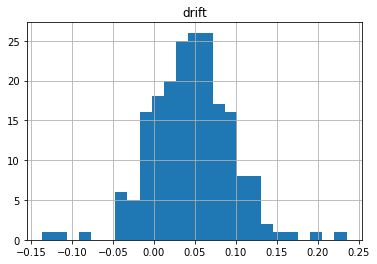

In [13]:
topicmeans.hist(column = 'drift', bins = 25)

## Careers

In [14]:
# standardize all the topic columns

career = bookdata.copy()
for i in range(200):
    career.iloc[ : , i] = zscore(career.iloc[ : , i])

In [15]:
dimensions = []
careerspans = []
careerchanges = []
careerabschanges = []

ctr = 0

for auth in authors:
    authworks = career.loc[career.hathi_author == auth, :].copy()   # get all the author's books
    authworks = authworks.sort_values(by = 'firstpub')              # sort them by date
    
    cspan = authworks.iat[len(authworks) - 1, 207] - authworks.iat[0, 207]
    
    for tnum in range(200):
        thischange = authworks.iat[len(authworks) - 1, tnum] - authworks.iat[0, tnum]
        dimensions.append(tnum)
        careerspans.append(cspan)
        careerchanges.append(thischange)
        careerabschanges.append(abs(thischange))
    
    ctr += 1
    
    if ctr % 500 == 1:
        print(ctr)
    

1
501
1001
1501


In [16]:
careervariation = pd.DataFrame({'topic': dimensions, 'spans': careerspans, 'changes': careerchanges, 'abschanges': careerabschanges})

weightedchanges = []
weightedabschanges = []
tnums = []

for tnum, df in careervariation.groupby('topic'):
    weightedchanges.append(np.average(df.changes, weights = df.spans))
    weightedabschanges.append(np.average(df.abschanges, weights = df.spans))
    tnums.append(tnum)

careerdf = pd.DataFrame({'topic': tnums, 'change': weightedchanges, 'abschanges': weightedabschanges})

In [17]:
pearsonr(np.abs(careerdf.change), topicmeans.drift)

(0.35587819266494936, 2.3204128823635313e-07)

In [19]:
pearsonr(careerdf.abschanges, topicmeans.drift)

(0.016379029206642477, 0.8179379159141236)

In [21]:
topicmeans['meancareerchange'] = careerdf.change.values
topicmeans['abscareerchange'] = careerdf.abschanges.values

In [22]:
topicmeans.to_csv('changepersistence.tsv', sep = '\t', index = False)

## Evaluate overall relationship to age

Here we're looking at the Euclidean distance in topic space, for all topics at once.

In [23]:
euc = triplets.loc[triplets.dim == -1, : ]  # Dimension -1 is the euclidean distance in topic space

In [24]:
euc = euc.assign(midage = euc.initialage + (euc.agegap / 2))

In [25]:
predictors = euc.loc[ : , ['agegap']]
predictors = sm.add_constant(predictors, prepend = False)
mod = sm.OLS(euc['double'], predictors)
res = mod.fit()
residuals = res.resid
doubleresiduals = residuals + np.mean(euc['double'])
mod = sm.OLS(euc['single'], predictors)
res = mod.fit()
residuals = res.resid
singleresiduals = residuals + np.mean(euc['single'])

In [26]:
euc = euc.assign(doubleresid = doubleresiduals)
euc = euc.assign(singleresid = singleresiduals)

In [27]:
byage = euc.groupby('midage').agg({'dim': 'count', 'single': 'mean', 'double': 'mean', 'initialage': 'mean', 'agegap': 'mean',
                                  'singleresid': 'mean', 'doubleresid': 'mean'})

In [40]:
byage['drift'] = (byage.double / (byage.single / 2)) - 1
byage['correcteddrift'] = (byage.doubleresid / (byage.singleresid / 2)) - 1

In [35]:
byage.reset_index(inplace = True, drop = False)

<AxesSubplot:xlabel='midage'>

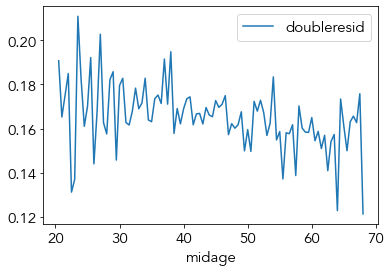

In [84]:
byage.iloc[0:95, : ].plot(x = 'midage', y = 'doubleresid')

<AxesSubplot:xlabel='midage'>

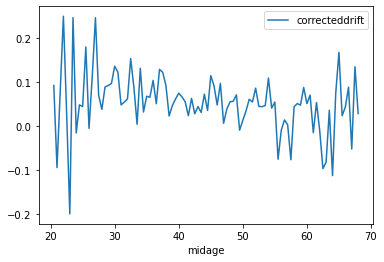

In [42]:
byage.iloc[0:95, : ].plot(x = 'midage', y = 'correcteddrift')

In [43]:
pearsonr(byage.initialage, byage.correcteddrift)

(-0.2177488779074449, 0.015981393577947325)

In [79]:
pearsonr(byage.midage, byage.doubleresid)

(-0.3703653468204429, 2.6805819576062237e-05)

In [44]:
pearsonr(byage.midage, byage.agegap)

(0.33756841380901564, 0.00014328928782025445)

In [47]:
pearsonr(byage.midage, byage.correcteddrift)

(-0.23286140372503744, 0.009847314429891368)

In [49]:
euc = euc.assign(drift = (euc.double / (euc.single / 2)) - 1)

In [50]:
predictors = euc.loc[ : , ['midage', 'agegap']]

In [51]:
predictors = sm.add_constant(predictors, prepend = False)
predictors.head()

,midage,agegap,const
0,28.0,4,1.0
201,35.0,2,1.0
402,59.5,3,1.0
603,43.0,16,1.0
804,33.0,2,1.0


In [52]:
mod = sm.OLS(euc['drift'], predictors)

In [53]:
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  drift   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     79.08
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           6.20e-35
Time:                        11:57:16   Log-Likelihood:                 1350.9
No. Observations:               19624   AIC:                            -2696.
Df Residuals:                   19621   BIC:                            -2672.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
midage        -0.0015      0.000     -9.628      0.0

In [54]:
res.params

midage   -0.001526
agegap    0.002179
const     0.122214
dtype: float64

In [75]:
res.pvalues

midage    6.793917e-22
agegap    8.516176e-21
const     1.155745e-59
dtype: float64

In [76]:
len(authors)

1714

### Visualize cumulative drift as a function of age

In [63]:
meanratio = []
upperratio = []
lowerratio = []
midyear = []

for yr in range(23, 68, 5):
    df = euc.loc[(euc.midage >= yr) & (euc.midage < yr + 5), :]
    meanratio.append(np.mean(df.doubleresid) / (np.mean(df.singleresid) / 2) - 1)
    midyear.append(yr + 2) # given the way>= and < work above this and not 2.5 is right
    bootstraps = []
    for iter in range(10000):
        dfsample = df.sample(frac = 1, replace = True)
        bootstraps.append(np.mean(dfsample.doubleresid) / (np.mean(dfsample.singleresid) / 2) - 1)
    
    bootstraps.sort()
    lowerratio.append(bootstraps[250])
    upperratio.append(bootstraps[9749])
    
    
displayframe = pd.DataFrame({'observed': meanratio, 'midpoint': midyear, 
                             'upper': upperratio, 'lower': lowerratio})   

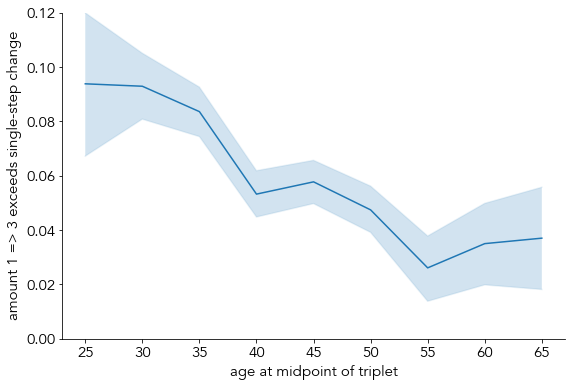

In [74]:
# Draw plot with error band and extra formatting to match seaborn style
plt.rcParams.update({'font.sans-serif':'Avenir'})
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(displayframe.midpoint, displayframe.observed, label='cumulative change')
ax.plot(displayframe.midpoint, displayframe.lower, color='tab:blue', alpha=0.1)
ax.plot(displayframe.midpoint, displayframe.upper, color='tab:blue', alpha=0.1)
ax.fill_between(displayframe.midpoint, displayframe.lower, displayframe.upper, alpha=0.2)
ax.set_xlabel('age at midpoint of triplet')
ax.set_ylabel('amount 1 => 3 exceeds single-step change')
ax.set_ylim(0, 0.12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gcf().set_facecolor('white')
plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/cumulativedrift.png', bbox_inches = 'tight', dpi = 300)
plt.show()

#### absolute value of change

In [85]:
meanratio = []
upperratio = []
lowerratio = []
midyear = []

for yr in range(23, 68, 5):
    df = euc.loc[(euc.midage >= yr) & (euc.midage < yr + 5), :]
    meanratio.append(np.mean(df.doubleresid))
    midyear.append(yr + 2) # given the way>= and < work above this and not 2.5 is right
    bootstraps = []
    for iter in range(10000):
        dfsample = df.sample(frac = 1, replace = True)
        bootstraps.append(np.mean(dfsample.doubleresid))
    
    bootstraps.sort()
    lowerratio.append(bootstraps[250])
    upperratio.append(bootstraps[9749])
    
    
displayframe2 = pd.DataFrame({'observed': meanratio, 'midpoint': midyear, 
                             'upper': upperratio, 'lower': lowerratio})  

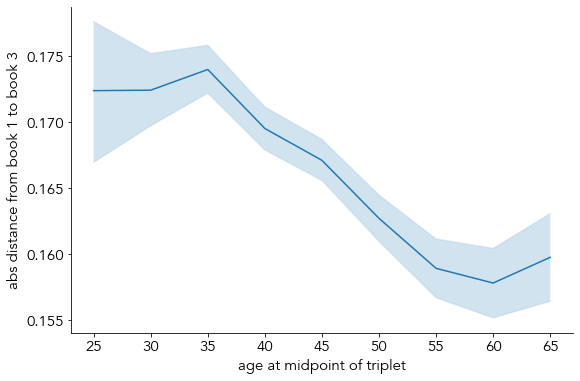

In [96]:
# Draw plot with error band and extra formatting to match seaborn style
plt.rcParams.update({'font.sans-serif':'Avenir'})
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(displayframe2.midpoint, displayframe2.observed, label='cumulative change')
ax.plot(displayframe2.midpoint, displayframe2.lower, color='tab:blue', alpha=0.1)
ax.plot(displayframe2.midpoint, displayframe2.upper, color='tab:blue', alpha=0.1)
ax.fill_between(displayframe2.midpoint, displayframe2.lower, displayframe2.upper, alpha=0.2)
ax.set_xlabel('age at midpoint of triplet')
ax.set_ylabel('abs distance from book 1 to book 3')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gcf().set_facecolor('white')
plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/absolutedistance1to3.png', bbox_inches = 'tight', dpi = 300)
plt.show()

## Model of totally random change, for reference.

In [105]:
averageonestep = []
realchange = []

startpoint = np.zeros(200)

for i in range(40000):
    a = startpoint + np.random.normal(size = 200)
    b = a + np.random.normal(size = 200)
    c = b + np.random.normal(size = 200)
    
    realchange.append(euclidean(a, c))
    averageonestep.append((euclidean(a, b) + euclidean(b, c)) / 2)

print(np.mean(realchange) / np.mean(averageonestep))

1.4147831306328424


I'm pretty sure that's not a random figure, but is in fact the square root of 2. 

Which means the parameter we're assessing would be .414 in a random walk.

## What if we sample authors proportional to productivity?

In [320]:
weightedauthors = random.choices(bookdata.hathi_author.values, k = 10000) # randomly select author names
        # with replacement, from a list where authors appear once for each book

weightedtriads = maketriplets(weightedauthors)

1
501
1001
1501
2001
2501
3001
3501
4001
4501
5001
5501
6001
6501
7001
7501
8001
8501
9001
9501
Errors:  110


<AxesSubplot:xlabel='midage'>

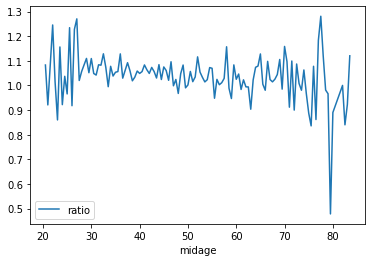

In [321]:
euc = weightedtriads.loc[weightedtriads.dim == -1, : ]  # Dimension -1 is the euclidean distance in topic space
euc = euc.assign(midage = euc.initialage + (euc.agegap / 2))
byage = euc.groupby('midage').agg({'dim': 'count', 'single': 'mean', 'double': 'mean', 'initialage': 'mean', 'agegap': 'mean'})
byage['ratio'] = byage.double / byage.single
byage.reset_index(inplace = True, drop = False)
byage.plot(x = 'midage', y = 'ratio')

In [324]:
pearsonr(byage.midage, byage.ratio)

(-0.2869185385554858, 0.0012930443070269125)

In [325]:
euc = euc.assign(ratio = euc.double / euc.single)
predictors = euc.loc[ : , ['midage', 'agegap']]
predictors = sm.add_constant(predictors, prepend = False)
mod = sm.OLS(euc['ratio'], predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     44.10
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           8.58e-20
Time:                        18:05:14   Log-Likelihood:                 549.93
No. Observations:                9890   AIC:                            -1094.
Df Residuals:                    9887   BIC:                            -1072.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
midage        -0.0014      0.000     -6.440      0.0

## Autocorrelation

This portion is not used because it turns out that there's no great way to measure autocorrelation across lots of short time series at different scales.

In [56]:
def makeautocorr(authorselection):
    
    # We create a list for each of the 1-5 columns described above

    dimensions = []
    tminus1 = []
    tminus0 = []
    meanage = []
    agegaps = []

    ctr = 0
    errors = 0


    for auth in authorselection:
        authworks = bookdata.loc[bookdata.hathi_author == auth, :].copy()   # get all the author's books
        authworks = authworks.sample(frac = 1)                                # shuffle them
        authworks = authworks.drop_duplicates(subset = 'firstpub', keep = 'first') # keep only one per date
        authworks = authworks.sort_values(by = 'firstpub')              # sort them by date

        if len(authworks) < 3:      # this could happen if an author has only 3 works and 2 are date-duplicates
            errors += 1
            continue

        centerpoints = [x for x in range(1, len(authworks) - 1)]            # a triad cannot be centered on the first
                                                                            # or last book

        rownum = random.choice(centerpoints)             # randomly choose an allowable book as triad center

        prevage = int(authworks.iloc[rownum - 1, 207])   # also get author's age at start of triad
        thisage = int(authworks.iloc[rownum, 207])
        nextage = int(authworks.iloc[rownum + 1, 207])
        agegap = nextage - prevage

        for tnum in range(0, 200): # and then for each topic tnum
            
            # authworks.iloc[ : , tnum] = zscore(authworks.iloc[ : , tnum])

            prevwork = authworks.iat[rownum -1, tnum]    # get the previous value of tnum
            thiswork = authworks.iat[rownum, tnum]       # the one at triad center
            nextwork = authworks.iat[rownum + 1, tnum]   # and the next value of tnum

            dimensions.append(tnum)
            tminus1.append(prevwork)
            tminus0.append(thiswork)
            meanage.append((prevage + thisage) / 2)
            agegaps.append((thisage - prevage))

            dimensions.append(tnum)
            tminus1.append(thiswork)
            tminus0.append(nextwork)
            meanage.append((thisage + nextage) / 2)
            agegaps.append((nextage - thisage))

        ctr += 1
        if ctr % 500 == 1:
            print(ctr)

    autocorr = pd.DataFrame({'dim': dimensions, 'minus1': tminus1, 'minus0': tminus0, 'meanage': meanage,
                            'agegap': agegaps})
    
    print('Errors: ', errors)
    
    return autocorr

In [57]:
equalauthors = random.choices(authors, k = 1000) # randomly select author names
                                                 # with replacement, from a list
        # where each author is present once, without regard to # of books
        # We're selecting most authors much more than once, but then, a lot of them
        # have more than one possible triplet

autocorr = makeautocorr(equalauthors)

1
501
Errors:  28


In [58]:
corrs = []

for i in range(200):
    df = autocorr.loc[autocorr.dim == i, : ]
    r = pearsonr(df.minus1, df.minus0)[0]
    corrs.append(r)

In [59]:
pearsonr(corrs, topicmeans.ratio)

(0.40697464712002024, 2.227184629589719e-09)

<AxesSubplot:ylabel='ratio'>

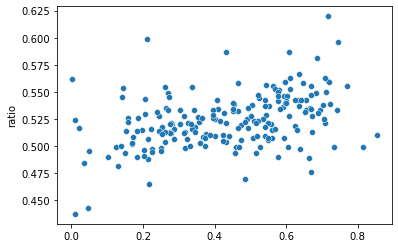

In [60]:
sns.scatterplot(x = corrs, y = topicmeans.ratio)

<AxesSubplot:xlabel='minus0', ylabel='minus1'>

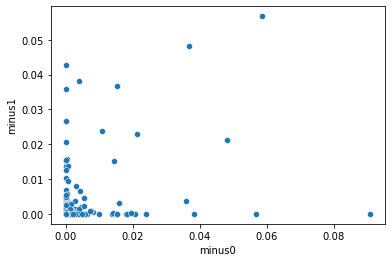

In [61]:
sns.scatterplot(x = df.minus0, y = df.minus1)